# CounterFactual Experiment

This notebook demonstrates the generation and visualization of counterfactual explanations using DPG constraints.

## Import Libraries

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from typing import cast
from sklearn.utils import Bunch

from CounterFactualModel import CounterFactualModel
from ConstraintParser import ConstraintParser
from CounterFactualVisualizer import plot_pca_with_counterfactual, plot_sample_and_counterfactual_heatmap
from CounterFactualExplainer import CounterFactualExplainer

import itertools

import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

# Define consistent class colors for the entire notebook
CLASS_COLORS = {
    'Class 0': 'purple',
    'Class 1': 'green',
    'Class 2': 'orange'
}

# Alternative: Color list by index
CLASS_COLORS_LIST = ['purple', 'green', 'orange']

## Training Machine Learning Model

In [2]:
# Load the Iris dataset
iris: Bunch = cast(Bunch, load_iris())
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a RandomForestClassifier with 3 base learners
model = RandomForestClassifier(n_estimators=3, random_state=42)
model.fit(X_train, y_train)

,n_estimators,3
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Opening Constraints Extracted from DPG

{'Class 0': [{'feature': 'petal_length', 'min': None, 'max': 5.05}, {'feature': 'petal_width', 'min': None, 'max': 1.75}, {'feature': 'sepal_length', 'min': 5.15, 'max': 6.15}, {'feature': 'sepal_width', 'min': 2.8, 'max': 3.25}], 'Class 1': [{'feature': 'petal_length', 'min': 2.15, 'max': 5.45}, {'feature': 'petal_width', 'min': 0.6, 'max': 1.9}, {'feature': 'sepal_length', 'min': 4.95, 'max': 7.1}, {'feature': 'sepal_width', 'min': 2.25, 'max': 3.7}], 'Class 2': [{'feature': 'petal_length', 'min': 2.35, 'max': 5.25}, {'feature': 'petal_width', 'min': 0.6, 'max': 1.9}, {'feature': 'sepal_length', 'min': 4.95, 'max': 6.75}, {'feature': 'sepal_width', 'min': 2.25, 'max': 3.25}]}

=== Side-by-Side View ===


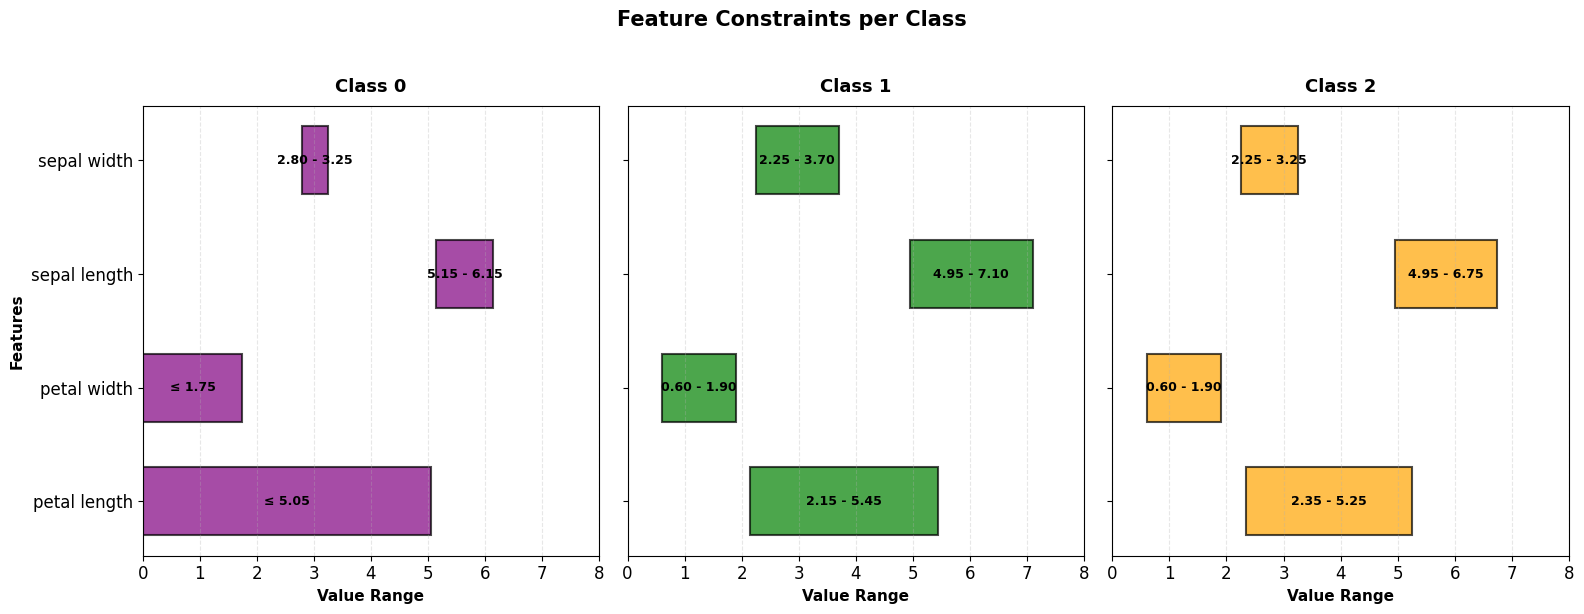


=== Overlapping View ===


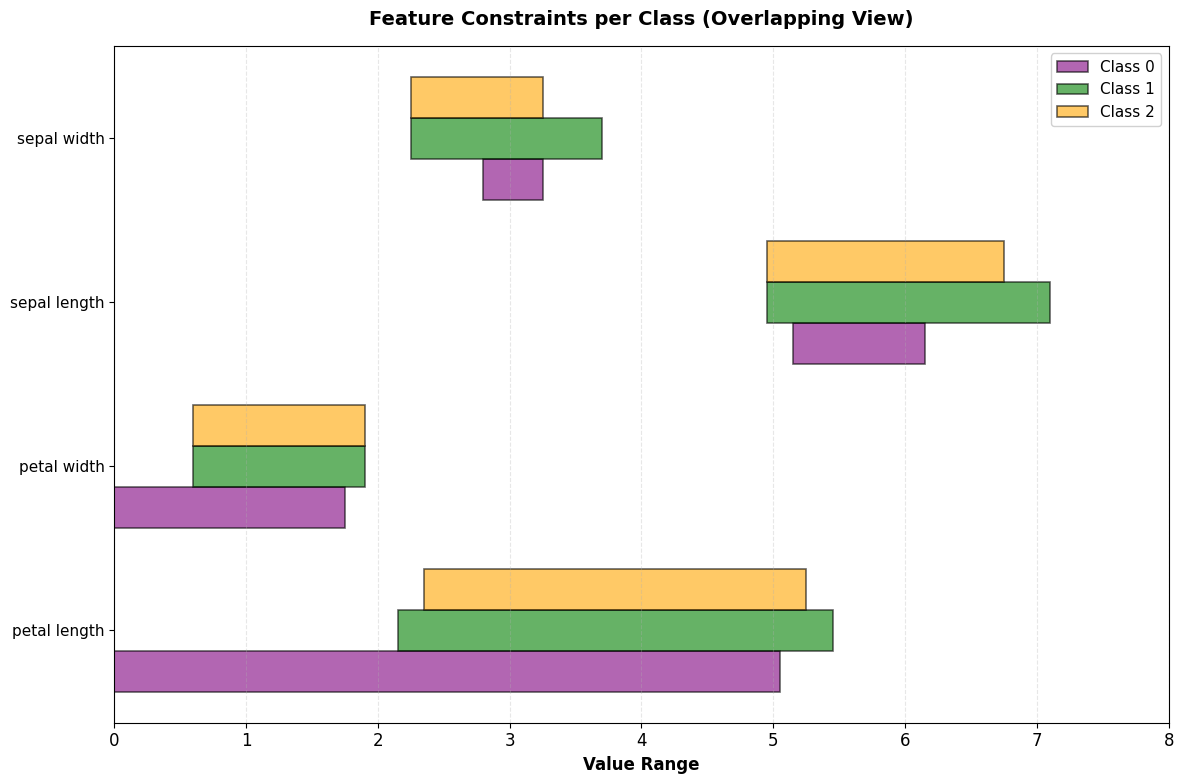

In [3]:
parser = ConstraintParser("constraints/custom_l100_pv0.001_t2_dpg_metrics.txt")
constraints = parser.read_constraints_from_file()
print(constraints)

# Visualize constraints
import matplotlib.pyplot as plt
import numpy as np

def plot_constraints(constraints, overlapping=False):
    """
    Visualize feature constraints for each class using horizontal bar ranges.
    
    Parameters:
    -----------
    constraints : dict
        Dictionary of constraints per class
    overlapping : bool
        If True, show all classes overlapping on one plot.
        If False, show classes side-by-side (default).
    """
    # Extract unique features
    features = []
    for class_name in constraints:
        for constraint in constraints[class_name]:
            feature = constraint['feature'].replace('_', ' ')
            if feature not in features:
                features.append(feature)
    
    # Use global class colors
    class_names = list(constraints.keys())
    colors = [CLASS_COLORS.get(cn, CLASS_COLORS_LIST[i]) for i, cn in enumerate(class_names)]
    
    if overlapping:
        # Single plot with overlapping bars
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        n_features = len(features)
        n_classes = len(constraints)
        
        # Calculate bar positions with offset for overlapping
        bar_height = 0.25
        y_positions = np.arange(n_features)
        
        for idx, class_name in enumerate(class_names):
            class_constraints = constraints[class_name]
            constraint_dict = {c['feature'].replace('_', ' '): c for c in class_constraints}
            
            # Offset each class slightly
            y_offset = (idx - n_classes/2 + 0.5) * bar_height
            
            for i, feature in enumerate(features):
                if feature in constraint_dict:
                    c = constraint_dict[feature]
                    min_val = c['min'] if c['min'] is not None else 0
                    max_val = c['max'] if c['max'] is not None else 10
                    
                    # Determine the range
                    if c['min'] is None:
                        # Only max constraint
                        ax.barh(i + y_offset, max_val, left=0, height=bar_height, 
                               color=colors[idx], alpha=0.6, edgecolor='black', 
                               linewidth=1.2, label=class_name if i == 0 else "")
                    elif c['max'] is None:
                        # Only min constraint
                        range_width = 10 - min_val
                        ax.barh(i + y_offset, range_width, left=min_val, height=bar_height, 
                               color=colors[idx], alpha=0.6, edgecolor='black', 
                               linewidth=1.2, label=class_name if i == 0 else "")
                    else:
                        # Both min and max
                        range_width = max_val - min_val
                        ax.barh(i + y_offset, range_width, left=min_val, height=bar_height, 
                               color=colors[idx], alpha=0.6, edgecolor='black', 
                               linewidth=1.2, label=class_name if i == 0 else "")
        
        ax.set_yticks(y_positions)
        ax.set_yticklabels(features, fontsize=11)
        ax.set_xlabel('Value Range', fontsize=12, fontweight='bold')
        ax.set_title('Feature Constraints per Class (Overlapping View)', 
                    fontsize=14, fontweight='bold', pad=15)
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        ax.set_xlim(0, 8)
        ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
        
        plt.tight_layout()
        plt.show()
        
    else:
        # Side-by-side plots (original view)
        n_classes = len(constraints)
        n_features = len(features)
        
        fig, axes = plt.subplots(1, n_classes, figsize=(16, 6), sharey=True)
        if n_classes == 1:
            axes = [axes]
        
        for idx, (class_name, ax) in enumerate(zip(constraints.keys(), axes)):
            class_constraints = constraints[class_name]
            
            # Create a dictionary for easy lookup
            constraint_dict = {c['feature'].replace('_', ' '): c for c in class_constraints}
            
            y_positions = np.arange(n_features)
            
            for i, feature in enumerate(features):
                if feature in constraint_dict:
                    c = constraint_dict[feature]
                    min_val = c['min'] if c['min'] is not None else 0
                    max_val = c['max'] if c['max'] is not None else 10
                    
                    # Determine the range
                    if c['min'] is None:
                        # Only max constraint
                        ax.barh(i, max_val, left=0, height=0.6, 
                               color=colors[idx], alpha=0.7, edgecolor='black', linewidth=1.5)
                        ax.text(max_val/2, i, f'≤ {max_val:.2f}', 
                               ha='center', va='center', fontweight='bold', fontsize=9)
                    elif c['max'] is None:
                        # Only min constraint
                        range_width = 10 - min_val  # Arbitrary max for visualization
                        ax.barh(i, range_width, left=min_val, height=0.6, 
                               color=colors[idx], alpha=0.7, edgecolor='black', linewidth=1.5)
                        ax.text(min_val + range_width/2, i, f'≥ {min_val:.2f}', 
                               ha='center', va='center', fontweight='bold', fontsize=9)
                    else:
                        # Both min and max
                        range_width = max_val - min_val
                        ax.barh(i, range_width, left=min_val, height=0.6, 
                               color=colors[idx], alpha=0.7, edgecolor='black', linewidth=1.5)
                        ax.text(min_val + range_width/2, i, f'{min_val:.2f} - {max_val:.2f}', 
                               ha='center', va='center', fontweight='bold', fontsize=9)
            
            ax.set_yticks(y_positions)
            ax.set_yticklabels(features)
            ax.set_xlabel('Value Range', fontsize=11, fontweight='bold')
            ax.set_title(f'{class_name}', fontsize=13, fontweight='bold', pad=10)
            ax.grid(axis='x', alpha=0.3, linestyle='--')
            ax.set_xlim(0, 8)
        
        axes[0].set_ylabel('Features', fontsize=11, fontweight='bold')
        plt.suptitle('Feature Constraints per Class', fontsize=15, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

# Show both views
print("\n=== Side-by-Side View ===")
plot_constraints(constraints, overlapping=False)

print("\n=== Overlapping View ===")
plot_constraints(constraints, overlapping=True)

In [4]:
# Example usage
validity = ConstraintParser.is_value_valid_for_class("Class 1", "petal width (cm)", 0.5, constraints)
print(validity)

True


## Prepare Sample Data

In [5]:
# Original sample
sample = {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}

# Create a DataFrame from the sample
sample_df = pd.DataFrame([sample])  # Wrapping sample in a list to create a DataFrame

## Generating Counterfactual Samples

In [6]:
# Initialize the CounterFactualDPG class with the model and constraints
cf_dpg = CounterFactualModel(model, constraints, verbose=True)  # Ensure you are using the correct constraints (nested_dict)
#dict_non_actionable = {'sepal width (cm)': 'no_change', 'sepal length (cm)': 'no_change'}
#dict_non_actionable = {'sepal width (cm)': 'no_change', 'sepal length (cm)': 'non_increasing'}
#dict_non_actionable = {'petal width (cm)': 'no_change', 'sepal length (cm)': 'non_decreasing'}
dict_non_actionable = {}

target_class = 0
cf_dpg.dict_non_actionable = dict_non_actionable
counterfactual = cf_dpg.generate_counterfactual(sample, target_class, 20, 1000)

****** Generation 1: Average Fitness = 24.1712, Best Fitness = 24.1712, fitness improvement = inf


****** Generation 2: Average Fitness = 24.5749, Best Fitness = 23.8054, fitness improvement = 0.3658
****** Generation 3: Average Fitness = 24.5329, Best Fitness = 23.0007, fitness improvement = 0.8047
****** Generation 4: Average Fitness = 24.2014, Best Fitness = 22.3075, fitness improvement = 0.6932
****** Generation 5: Average Fitness = 23.3064, Best Fitness = 21.8780, fitness improvement = 0.4295
****** Generation 6: Average Fitness = 22.3974, Best Fitness = 21.4084, fitness improvement = 0.4696
****** Generation 7: Average Fitness = 21.5482, Best Fitness = 20.6222, fitness improvement = 0.7862
****** Generation 8: Average Fitness = 21.1959, Best Fitness = 19.8524, fitness improvement = 0.7699
****** Generation 9: Average Fitness = 20.4765, Best Fitness = 19.4049, fitness improvement = 0.4475
****** Generation 10: Average Fitness = 20.2511, Best Fitness = 18.9979, fitness improvement = 0.4070
****** Generation 11: Average Fitness = 20.0777, Best Fitness = 19.1854, fitness improveme

Original: {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}
Generated Counterfactual: {'petal width (cm)': np.float64(6.1), 'petal length (cm)': np.float64(2.74), 'sepal length (cm)': np.float64(2.44), 'sepal width (cm)': np.float64(1.08)}
Predicted Class for Original Sample: [1]
Prediction Class CounterFactual [0]


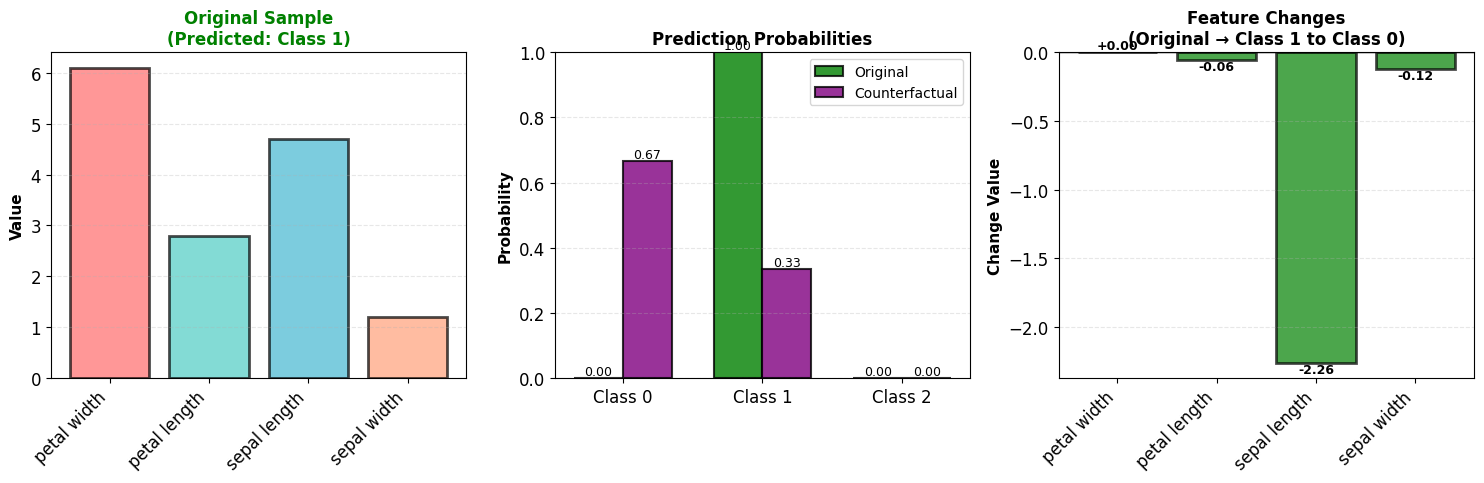


Summary:
  Original Class: 1 (GREEN)
  Target Class: 0 (PURPLE)
  Success: ✓ YES



In [7]:
print("Original:", sample)
print("Generated Counterfactual:", counterfactual)

predicted_class = model.predict(sample_df)
counterfactual_class = model.predict(pd.DataFrame([counterfactual]))
print("Predicted Class for Original Sample:", predicted_class)
print('Prediction Class CounterFactual', counterfactual_class)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Original Sample Features
feature_list = list(sample.keys())
original_values = list(sample.values())
colors_bar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
axes[0].bar(range(len(feature_list)), original_values, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_xticks(range(len(feature_list)))
axes[0].set_xticklabels([f.replace(' (cm)', '').replace('_', ' ') for f in feature_list], rotation=45, ha='right')
axes[0].set_ylabel('Value', fontsize=11, fontweight='bold')
axes[0].set_title(f'Original Sample\n(Predicted: Class {predicted_class[0]})', 
                  fontsize=12, fontweight='bold', color=CLASS_COLORS_LIST[predicted_class[0]])
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# 2. Class Probability Comparison
class_names = ['Class 0', 'Class 1', 'Class 2']
original_probs = model.predict_proba(sample_df)[0]
counterfactual_probs = model.predict_proba(pd.DataFrame([counterfactual]))[0]

x_pos = np.arange(3)
width = 0.35

bars1 = axes[1].bar(x_pos - width/2, original_probs, width, label='Original', 
                    color=CLASS_COLORS_LIST[predicted_class[0]], alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = axes[1].bar(x_pos + width/2, counterfactual_probs, width, label='Counterfactual', 
                    color=CLASS_COLORS_LIST[counterfactual_class[0]], alpha=0.8, edgecolor='black', linewidth=1.5)

axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(class_names)
axes[1].set_ylabel('Probability', fontsize=11, fontweight='bold')
axes[1].set_title('Prediction Probabilities', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].set_ylim(0, 1)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# 3. Feature Changes
counterfactual_values = list(counterfactual.values())
changes = [cf - orig for cf, orig in zip(counterfactual_values, original_values)]
change_colors = ['green' if c < 0 else 'red' if c > 0 else 'gray' for c in changes]

axes[2].bar(range(len(feature_list)), changes, color=change_colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[2].set_xticks(range(len(feature_list)))
axes[2].set_xticklabels([f.replace(' (cm)', '').replace('_', ' ') for f in feature_list], rotation=45, ha='right')
axes[2].set_ylabel('Change Value', fontsize=11, fontweight='bold')
axes[2].set_title(f'Feature Changes\n(Original → Class {predicted_class[0]} to Class {counterfactual_class[0]})', 
                  fontsize=12, fontweight='bold')
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[2].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, (change, feature) in enumerate(zip(changes, feature_list)):
    axes[2].text(i, change, f'{change:+.2f}', ha='center', 
                va='bottom' if change >= 0 else 'top', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"Summary:")
print(f"  Original Class: {predicted_class[0]} ({CLASS_COLORS_LIST[predicted_class[0]].upper()})")
print(f"  Target Class: {counterfactual_class[0]} ({CLASS_COLORS_LIST[counterfactual_class[0]].upper()})")
print(f"  Success: {'✓ YES' if predicted_class[0] != counterfactual_class[0] else '✗ NO'}")
print(f"{'='*60}\n")

## Visualizing Counterfactual Samples

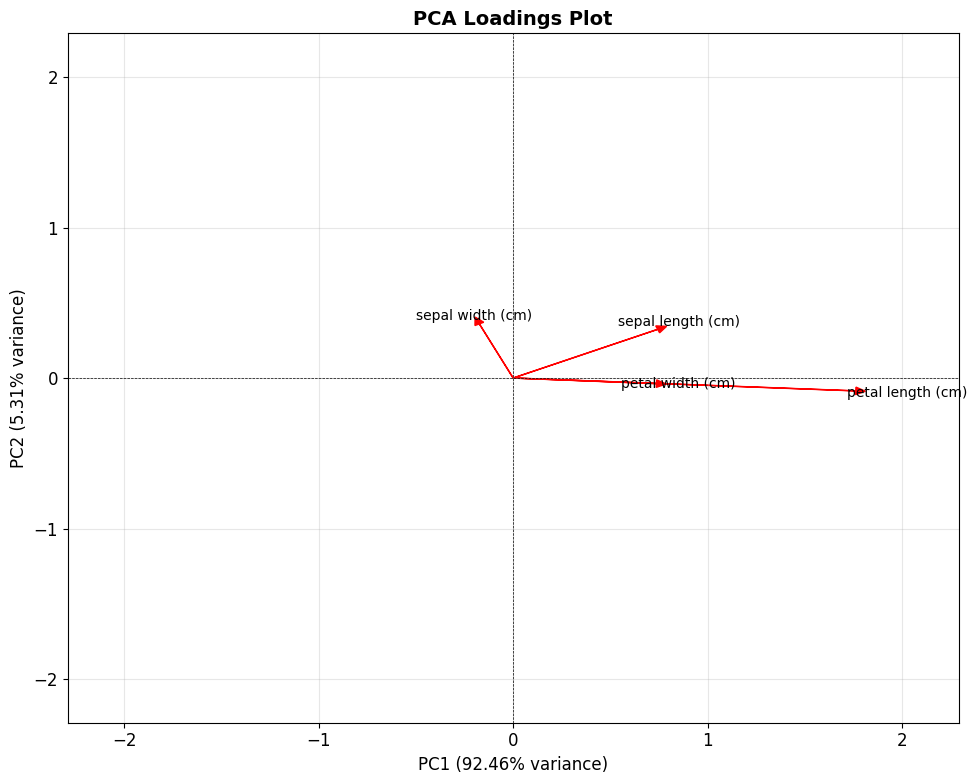

Explained variance by PC1: 92.46%
Explained variance by PC2: 5.31%
Total explained variance: 97.77%


In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def plot_pca_loadings(X, feature_names):
    """
    Plot PCA loadings to show feature contributions to principal components.
    
    Parameters:
    -----------
    X : array-like
        The feature data
    feature_names : list
        Names of the features
    """
    # Perform PCA
    pca = PCA(n_components=2)
    pca.fit(X)
    
    # Get the loadings (components)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot arrows for each feature
    for i, feature in enumerate(feature_names):
        ax.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
                head_width=0.05, head_length=0.05, fc='red', ec='red')
        ax.text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, 
               feature, ha='center', va='center', fontsize=10)
    
    # Set plot properties
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
    ax.set_title('PCA Loadings Plot', fontsize=14, fontweight='bold')
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    ax.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
    ax.grid(True, alpha=0.3)
    
    # Set equal aspect ratio
    max_val = np.abs(loadings).max() * 1.3
    ax.set_xlim(-max_val, max_val)
    ax.set_ylim(-max_val, max_val)
    
    plt.tight_layout()
    plt.show()
    
    # Print explained variance
    print(f"Explained variance by PC1: {pca.explained_variance_ratio_[0]:.2%}")
    print(f"Explained variance by PC2: {pca.explained_variance_ratio_[1]:.2%}")
    print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}")

# Plot the PCA loadings
plot_pca_loadings(X, iris.feature_names)

<module 'matplotlib.pyplot' from '/home/rafael/gitgud/CounterFactualDPG/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

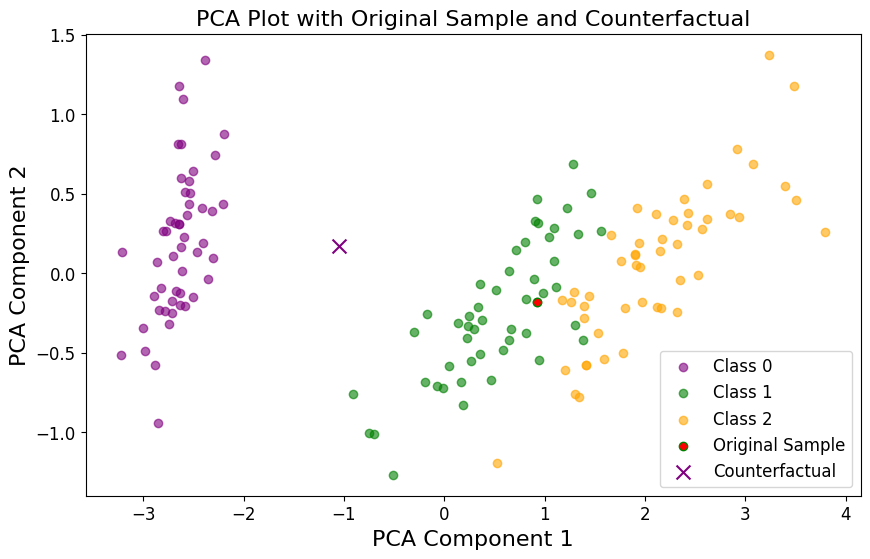

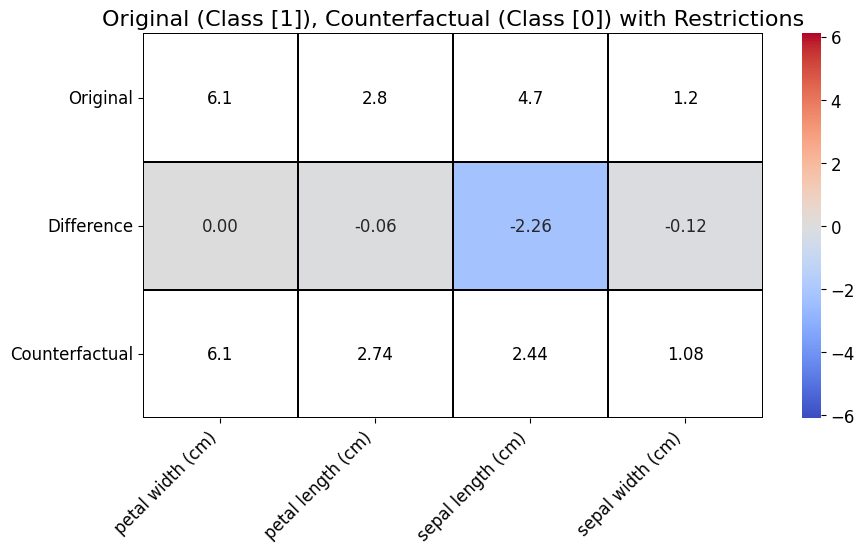

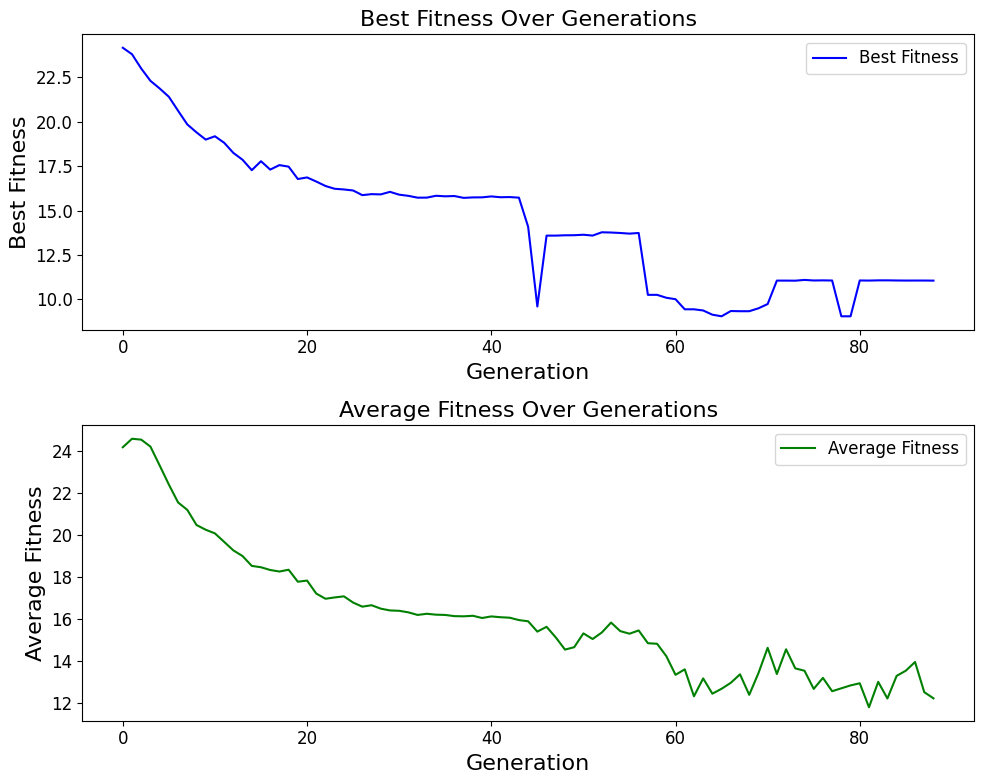

In [9]:
plot_pca_with_counterfactual(model, X, y, sample, counterfactual)
plot_sample_and_counterfactual_heatmap(sample, predicted_class, counterfactual,  model.predict(pd.DataFrame([counterfactual])),  dict_non_actionable)
cf_dpg.plot_fitness()

## Explaining Counterfactual Samples

## Generate Counterfactuals with All Rule Combinations

    petal width (cm)  petal length (cm)  sepal length (cm)  sepal width (cm)  \
0               3.83               0.96               3.43              3.23   
1               4.70               0.83               7.03              0.84   
2               4.64               1.37               7.23              3.24   
3               3.74               5.88               2.38              3.73   
4               3.70               5.89               6.45              0.81   
5               3.50               5.19               8.47              3.32   
6               7.21               1.16               2.43              3.07   
7              11.53               0.00               6.69              0.82   
8               8.09               1.33               8.05              3.77   
9              10.16               5.21               2.25              3.51   
10              7.83               7.53               9.95              0.84   
11              7.51               5.99 

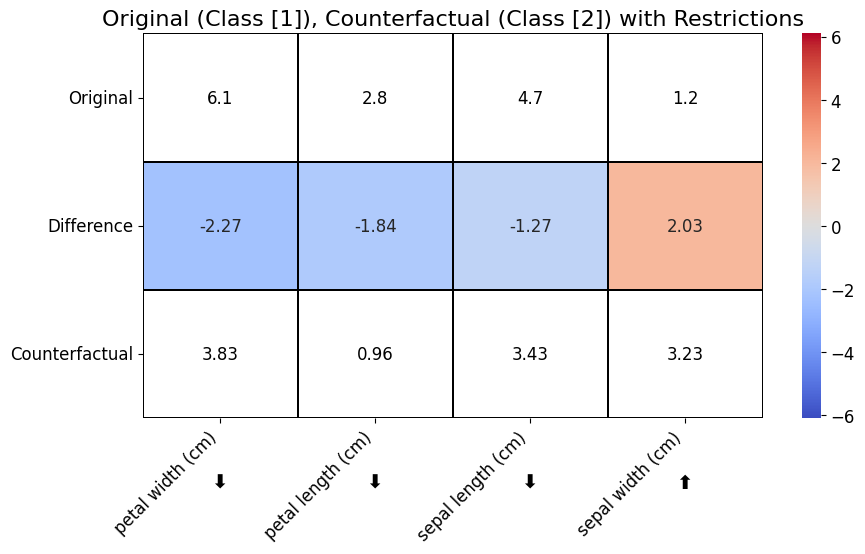

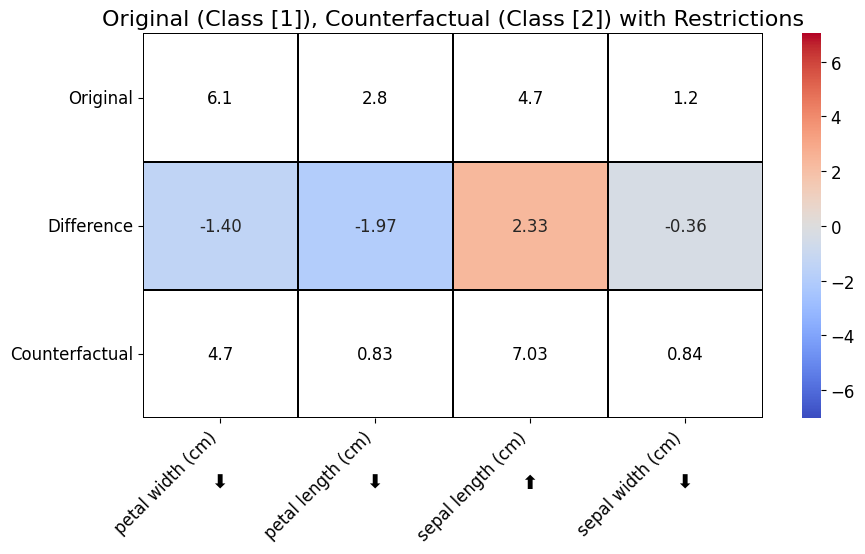

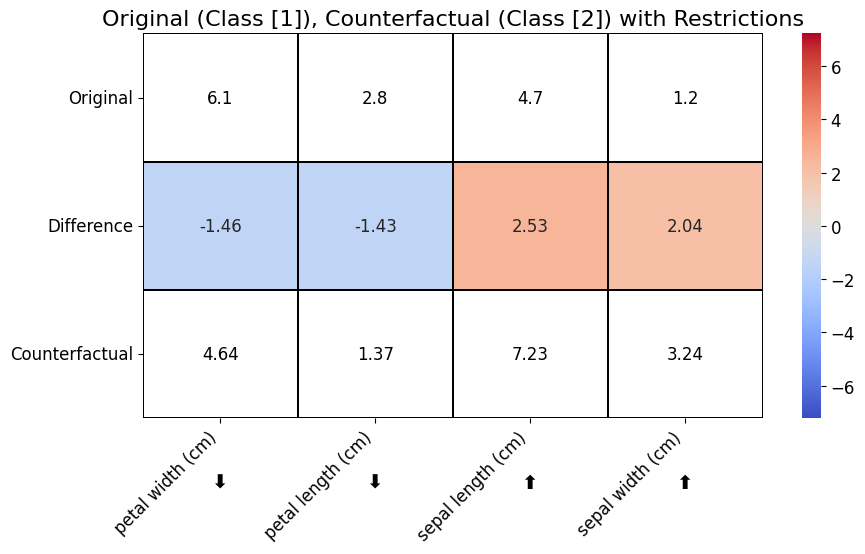

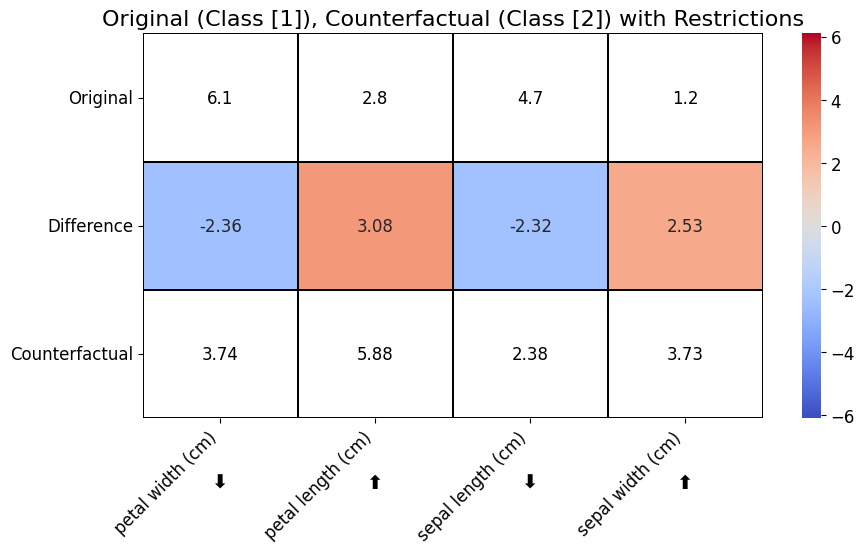

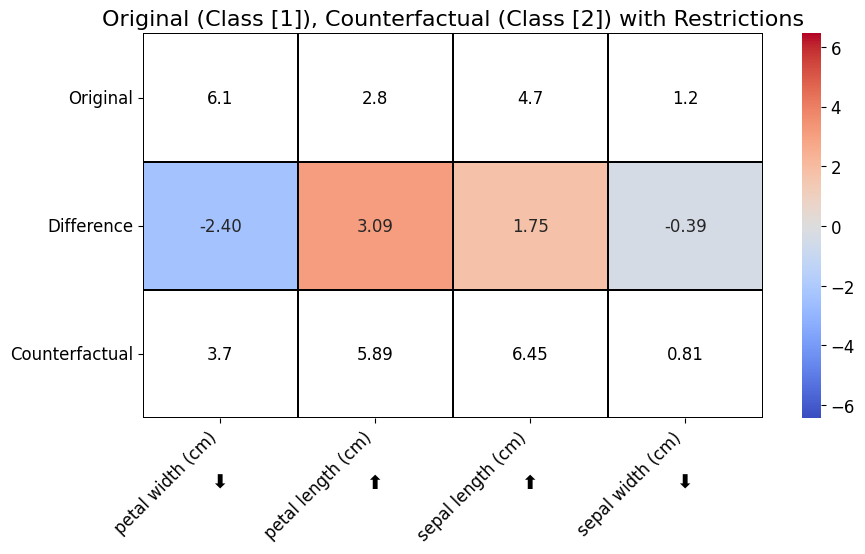

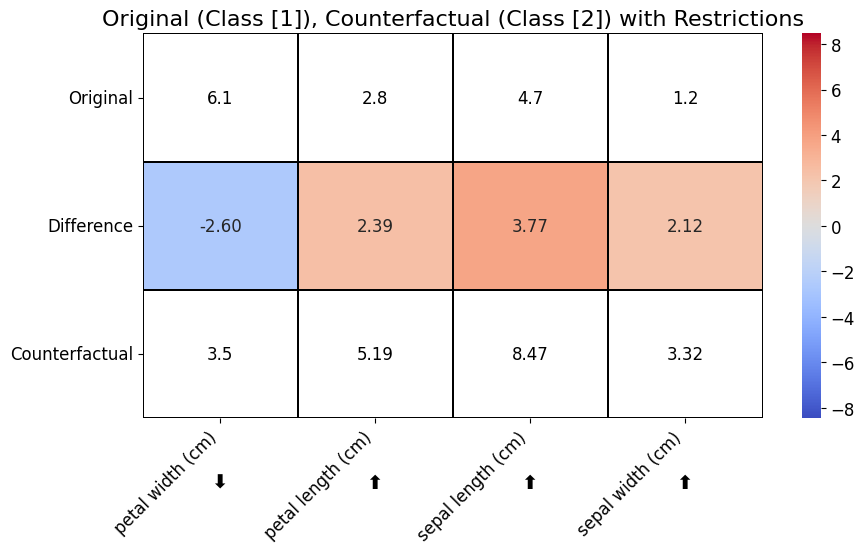

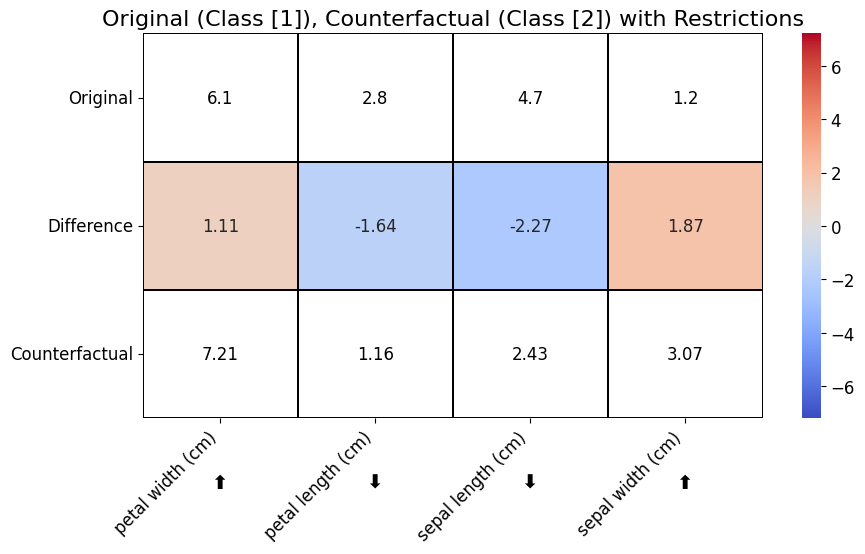

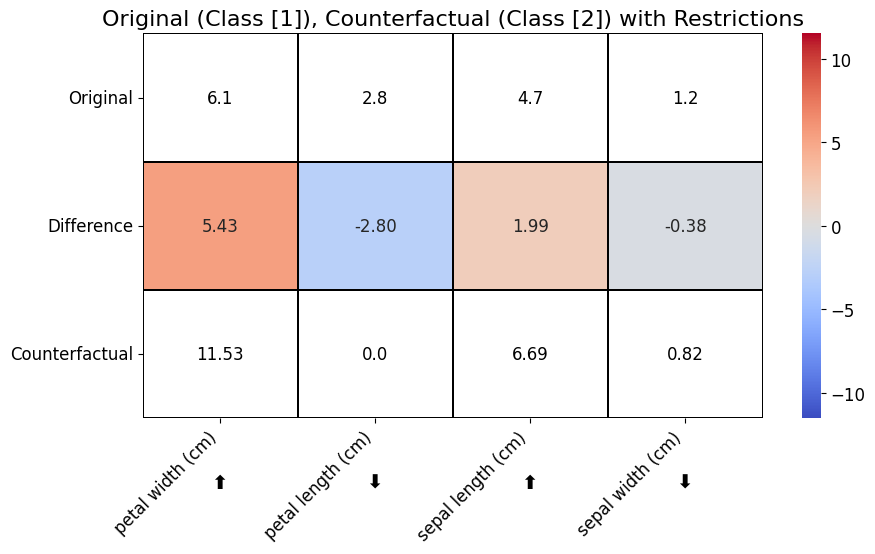

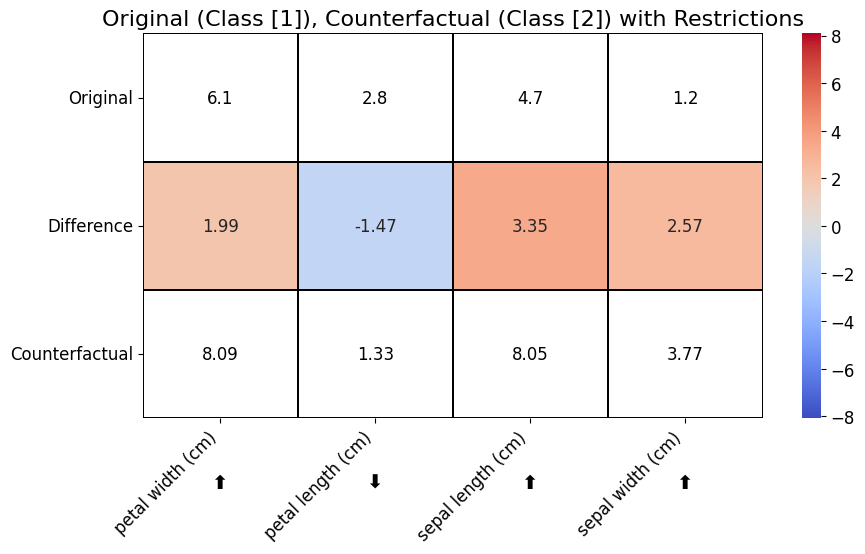

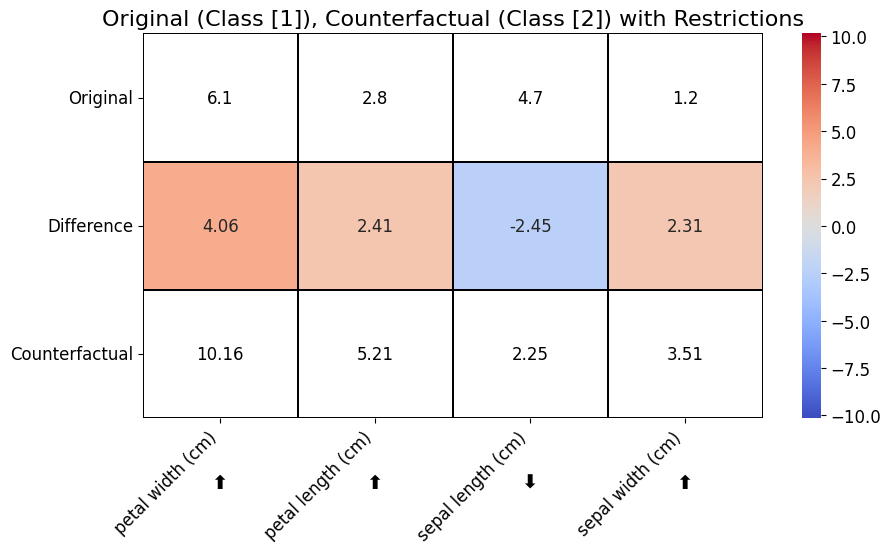

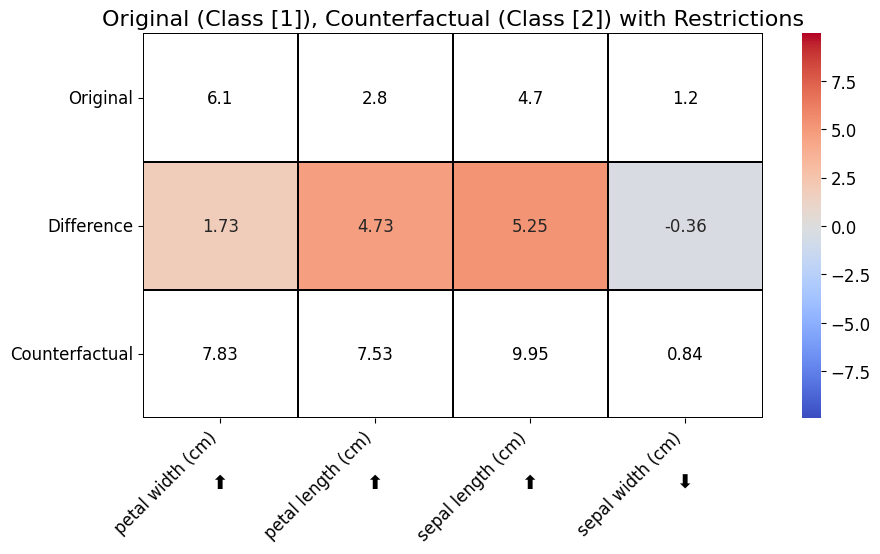

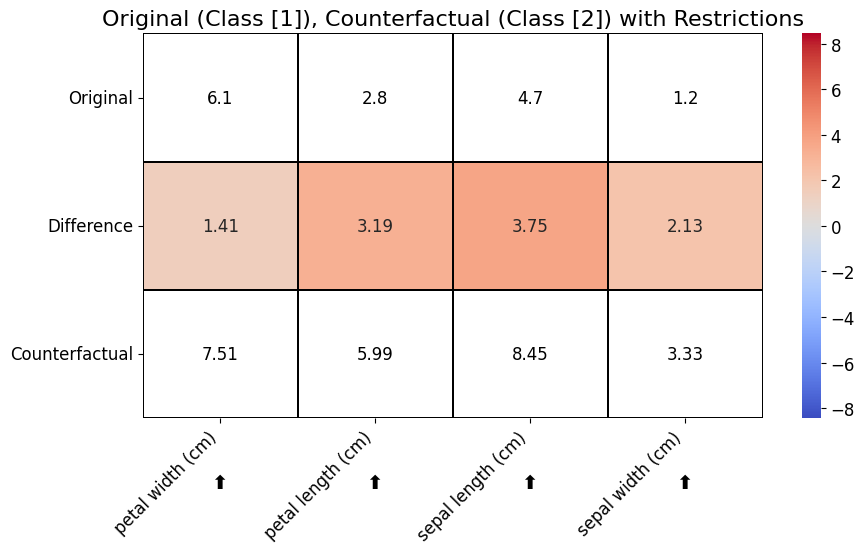

In [10]:
sample = {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}
rules = ['non_increasing', 'non_decreasing']

# Generate all possible combinations of rules for each feature
feature_names = list(sample.keys())
rule_combinations = list(itertools.product(rules, repeat=len(feature_names)))

counterfactuals_df_combinations = []

# Iterate through each combination of rules
for combination in rule_combinations:
    dict_non_actionable = dict(zip(feature_names, combination))

    # Create an instance of the CounterFactualModel class
    cf_dpg = CounterFactualModel(model, constraints)
    cf_dpg.dict_non_actionable = dict_non_actionable

    # Generate counterfactual
    counterfactual = cf_dpg.generate_counterfactual(sample, target_class=2)
    if (counterfactual == None):
        continue

    plot_sample_and_counterfactual_heatmap(sample, predicted_class, counterfactual,  model.predict(pd.DataFrame([counterfactual])),  dict_non_actionable)

    # Prepare data for DataFrame
    cf_data = counterfactual.copy()
    cf_data.update({'Rule_' + k: v for k, v in dict_non_actionable.items()})

    # Append to DataFrame
    counterfactuals_df_combinations.append(cf_data)

counterfactuals_df_combinations = pd.DataFrame(counterfactuals_df_combinations)
# Displaying the DataFrame
print(counterfactuals_df_combinations)

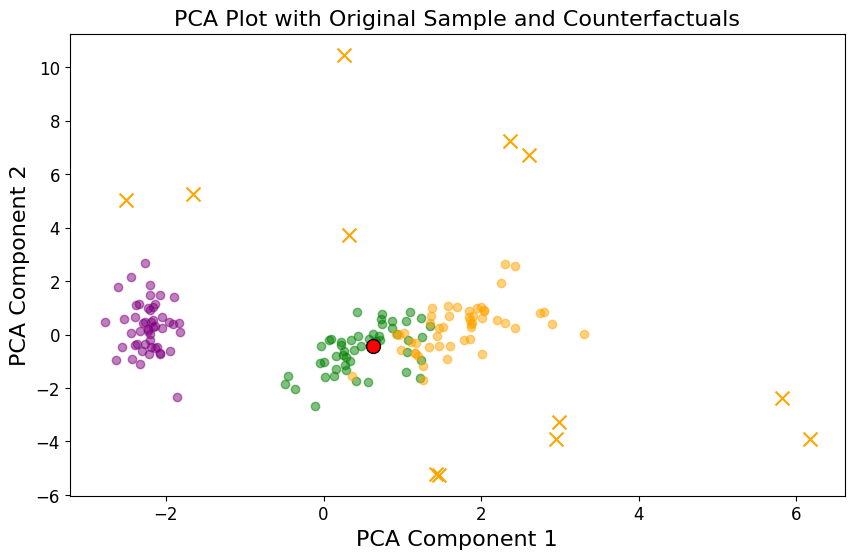

In [11]:
from CounterFactualVisualizer import plot_pca_with_counterfactuals

plot_pca_with_counterfactuals(model, pd.DataFrame(X), y, sample, counterfactuals_df_combinations)

## Generate Multiple Counterfactuals with Replications

In [12]:
explainer = CounterFactualExplainer(cf_dpg, sample, counterfactual, target_class)
print(explainer.explain_feature_modifications())
print(explainer.check_constraints_respect())
print(explainer.explain_stopping_criteria())
print(explainer.summarize_final_results())

Feature 'petal width (cm)' changed from 6.1 to 7.51.
Feature 'petal length (cm)' changed from 2.8 to 5.99.
Feature 'sepal length (cm)' changed from 4.7 to 8.45.
Feature 'sepal width (cm)' changed from 1.2 to 3.33.
All constraints were respected.
Stopping criteria not set or not reached.
Original class: 1, Counterfactual class: 2
Original fitness: inf, Best fitness: inf


    petal width (cm)  petal length (cm)  sepal length (cm)  sepal width (cm)  \
0               6.20               2.55               4.97              0.65   
1               6.10               2.88               5.45              0.34   
2               6.10               2.59               5.40              0.81   
3               6.10               3.51               5.09              0.48   
4               6.10               2.29               4.97              0.81   
5               6.10               2.85               5.49              0.81   
6               6.10               3.12               4.92              0.81   
7               5.92               3.08               5.99              0.65   
8               5.90               3.06               5.60              0.81   
9               6.31               2.85               5.41              0.81   
10              5.91               2.80               5.55              0.81   
11              5.52               2.80 

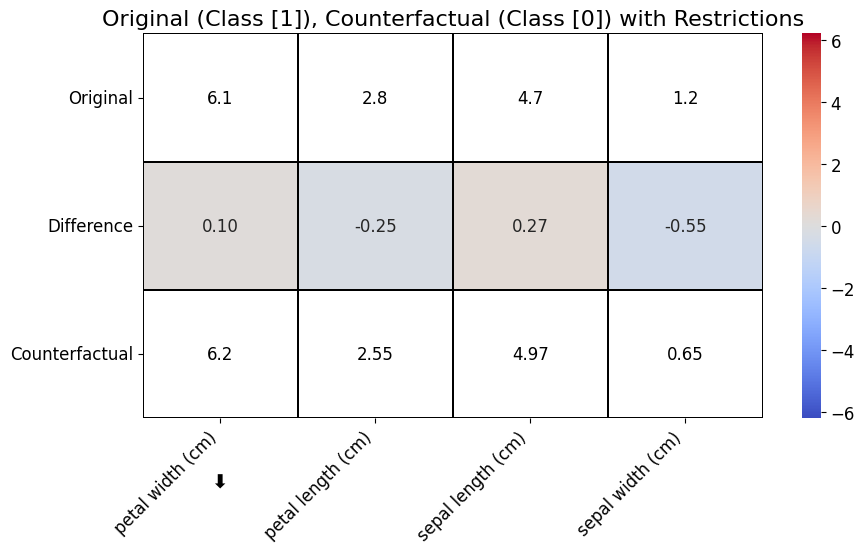

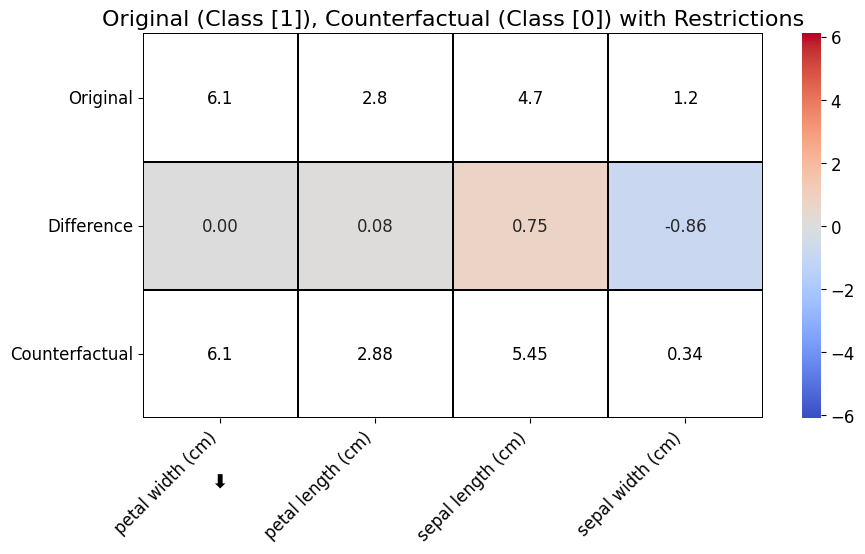

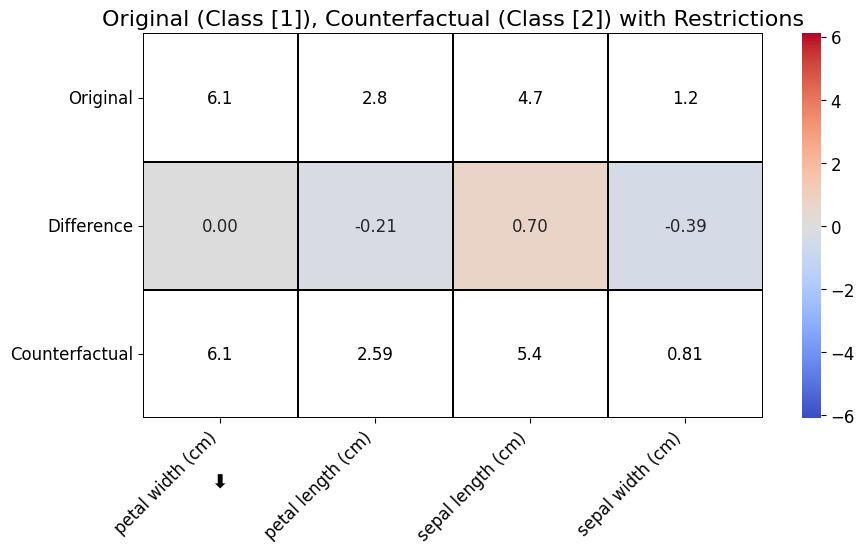

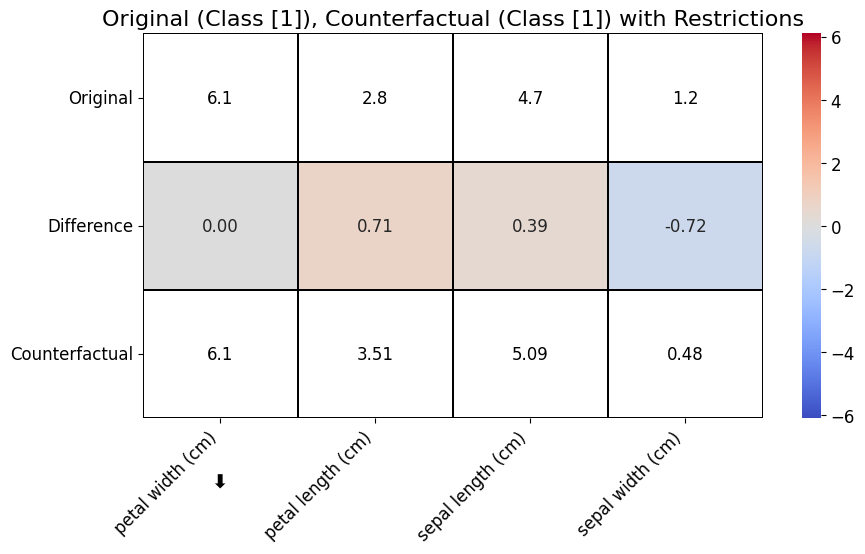

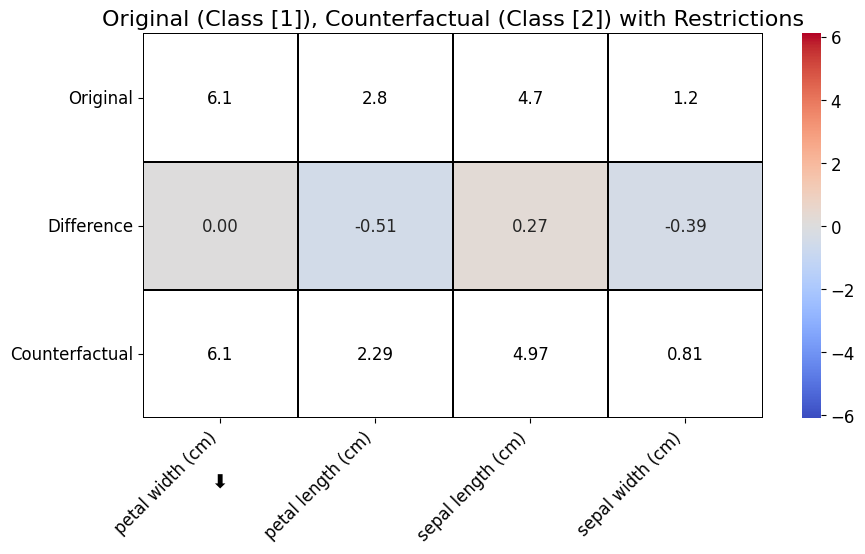

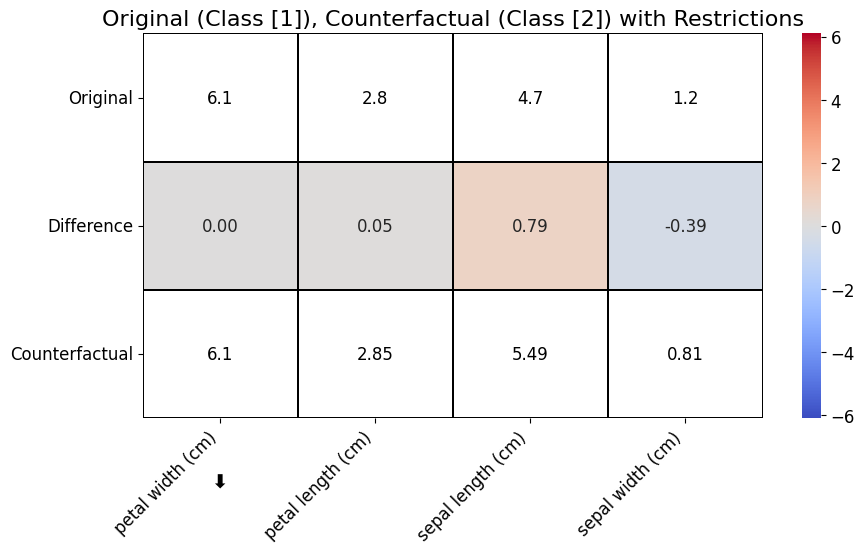

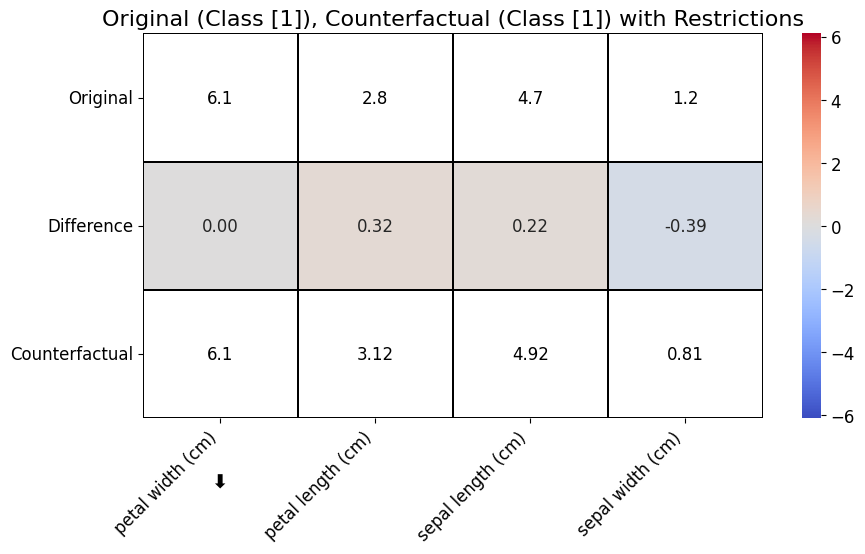

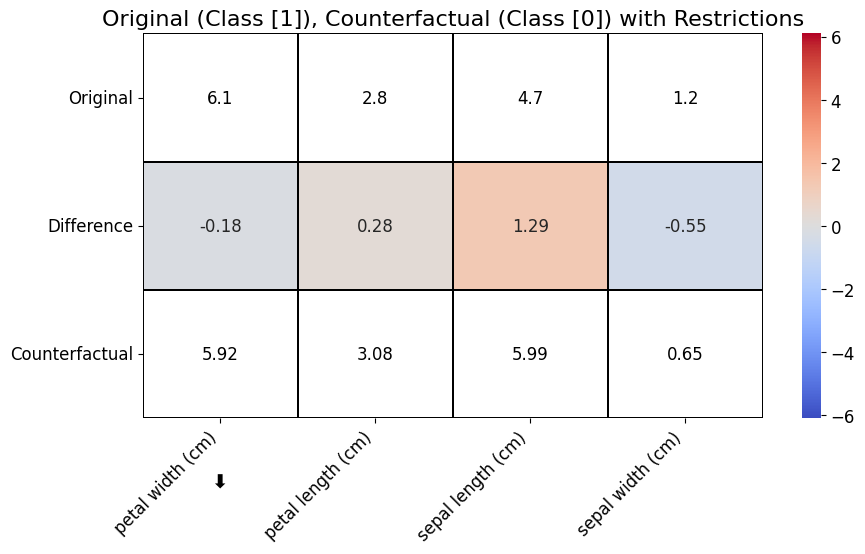

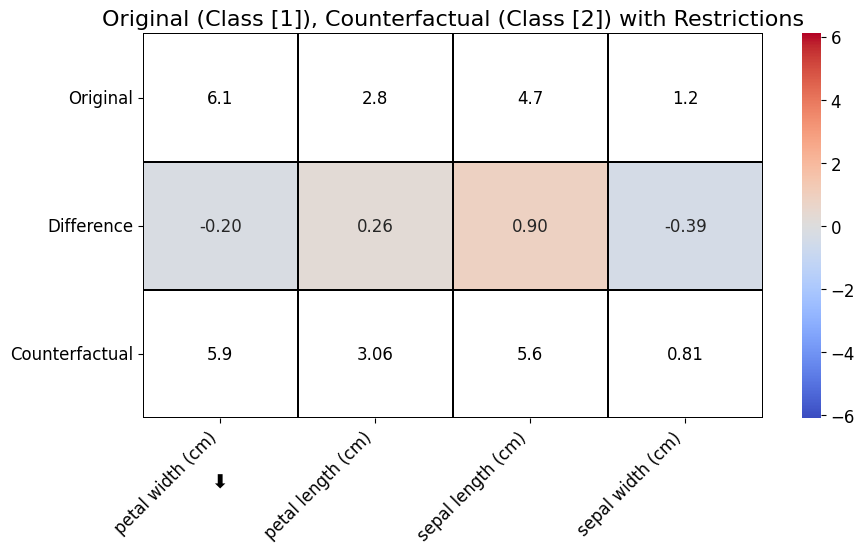

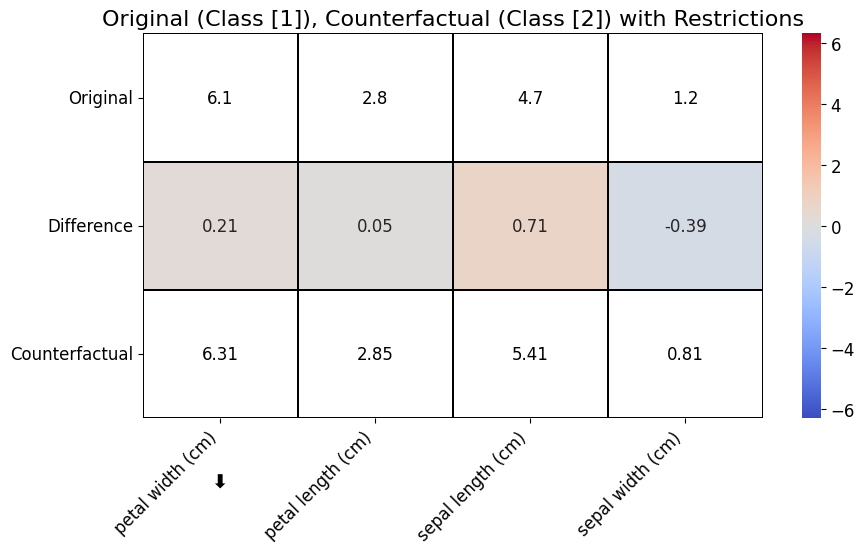

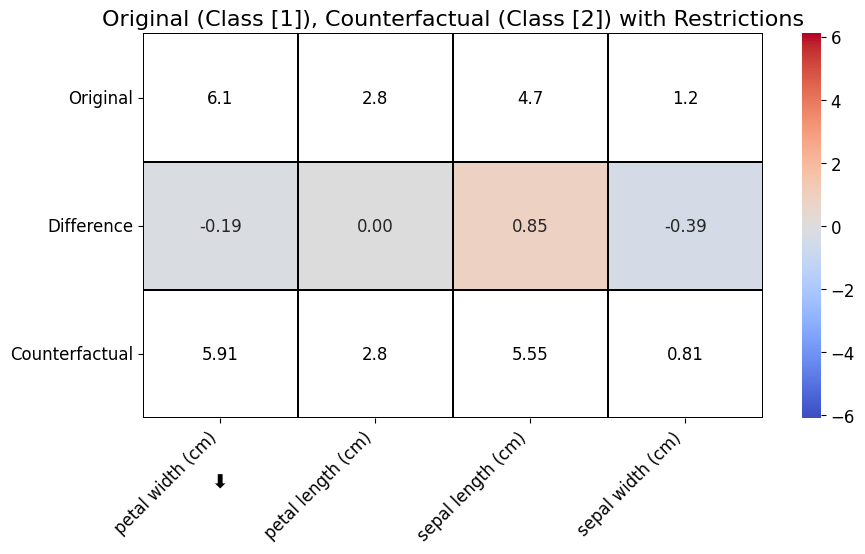

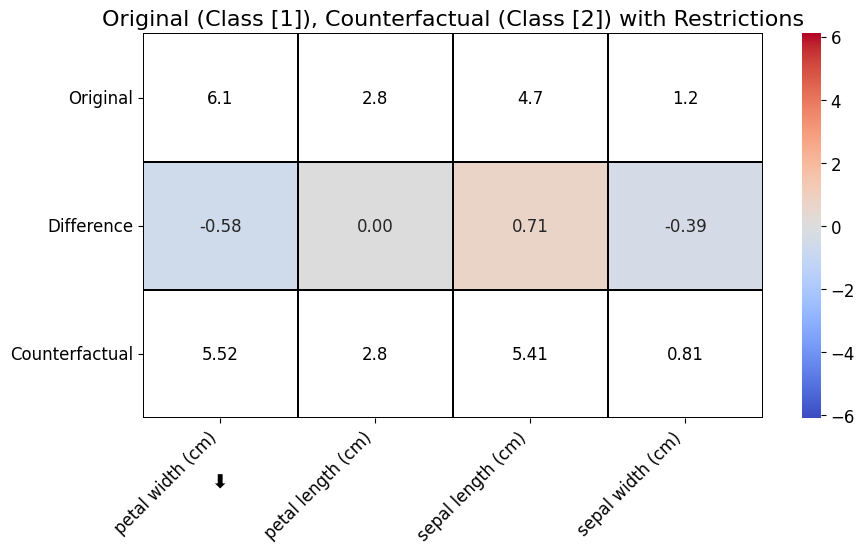

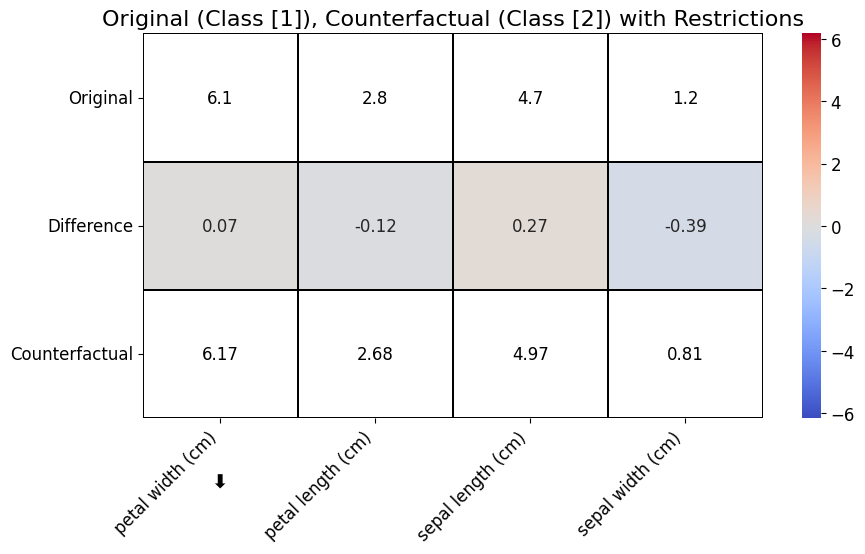

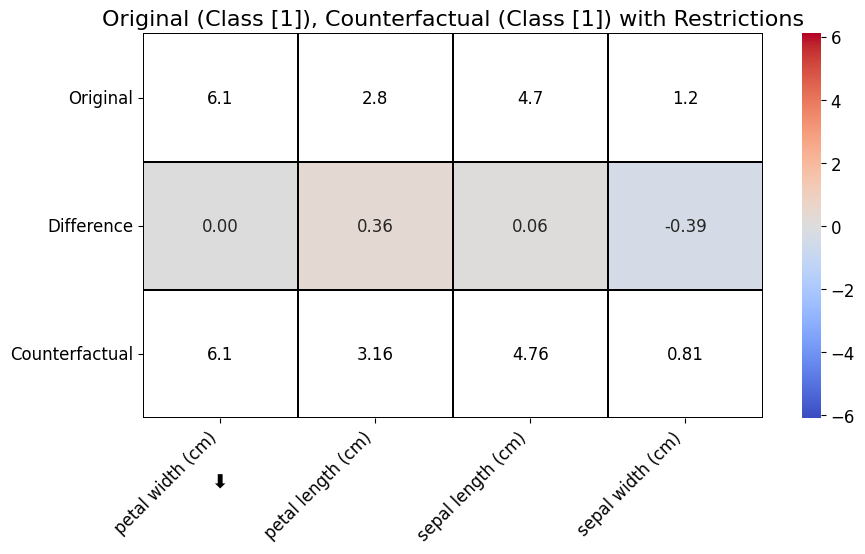

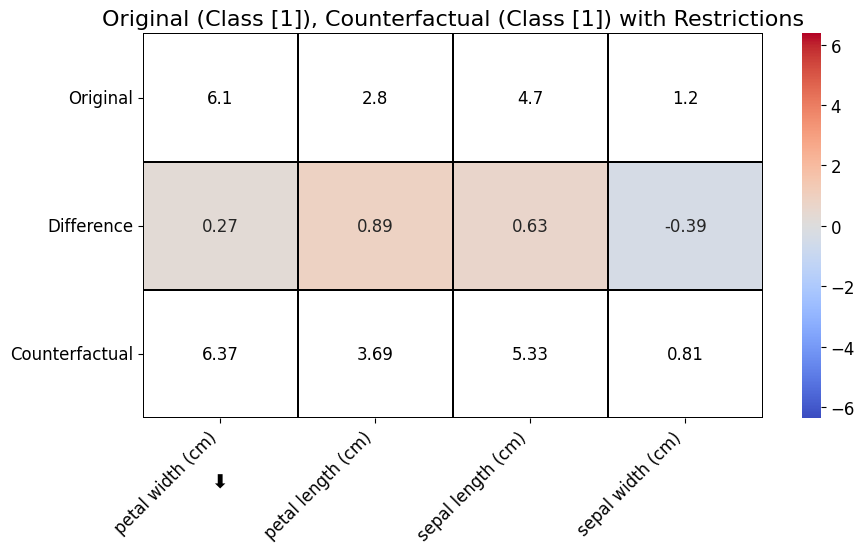

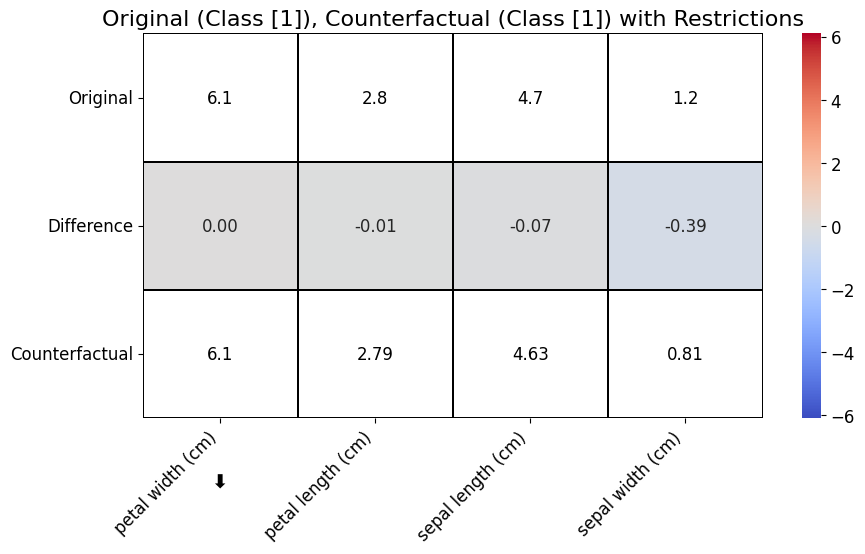

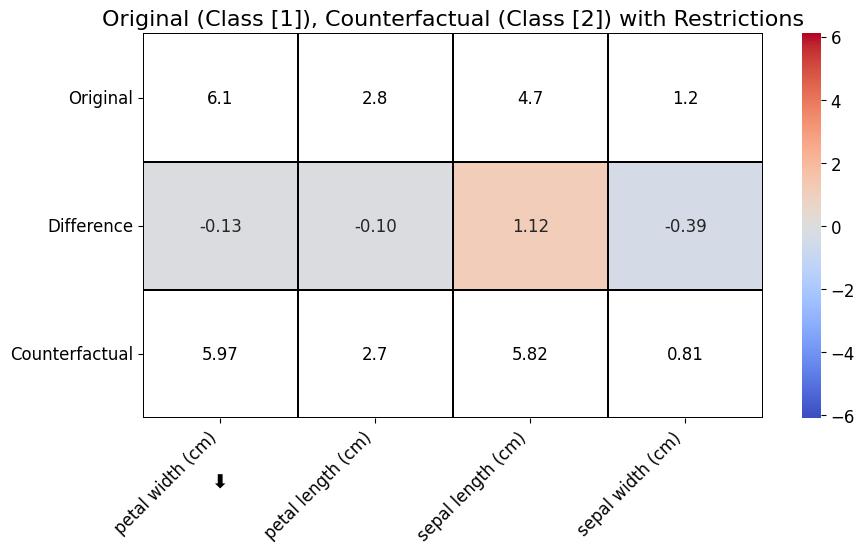

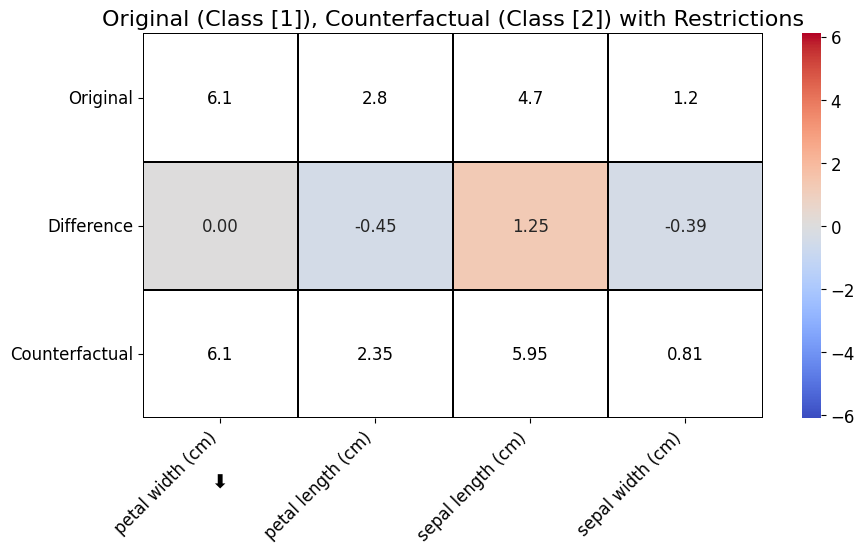

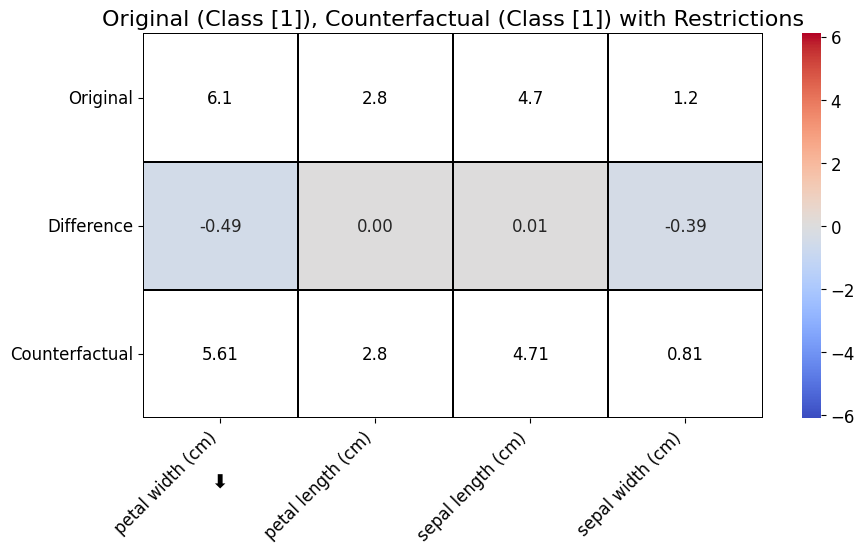

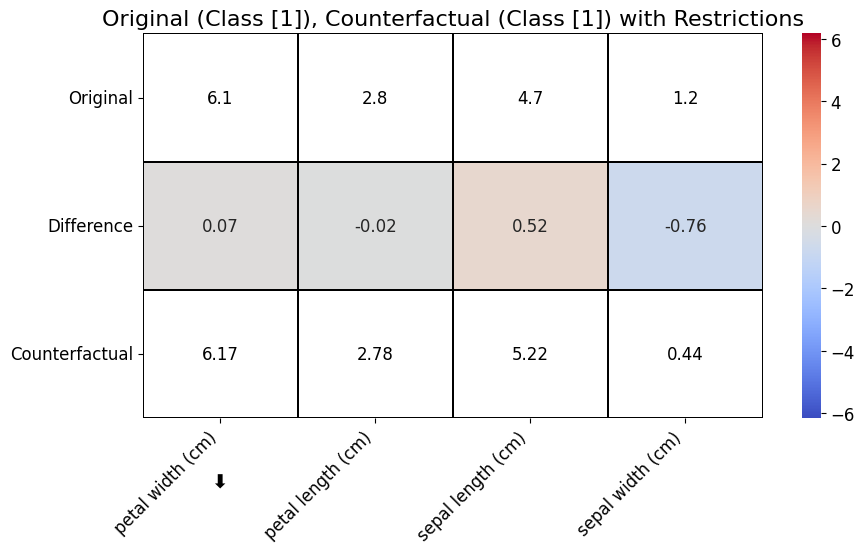

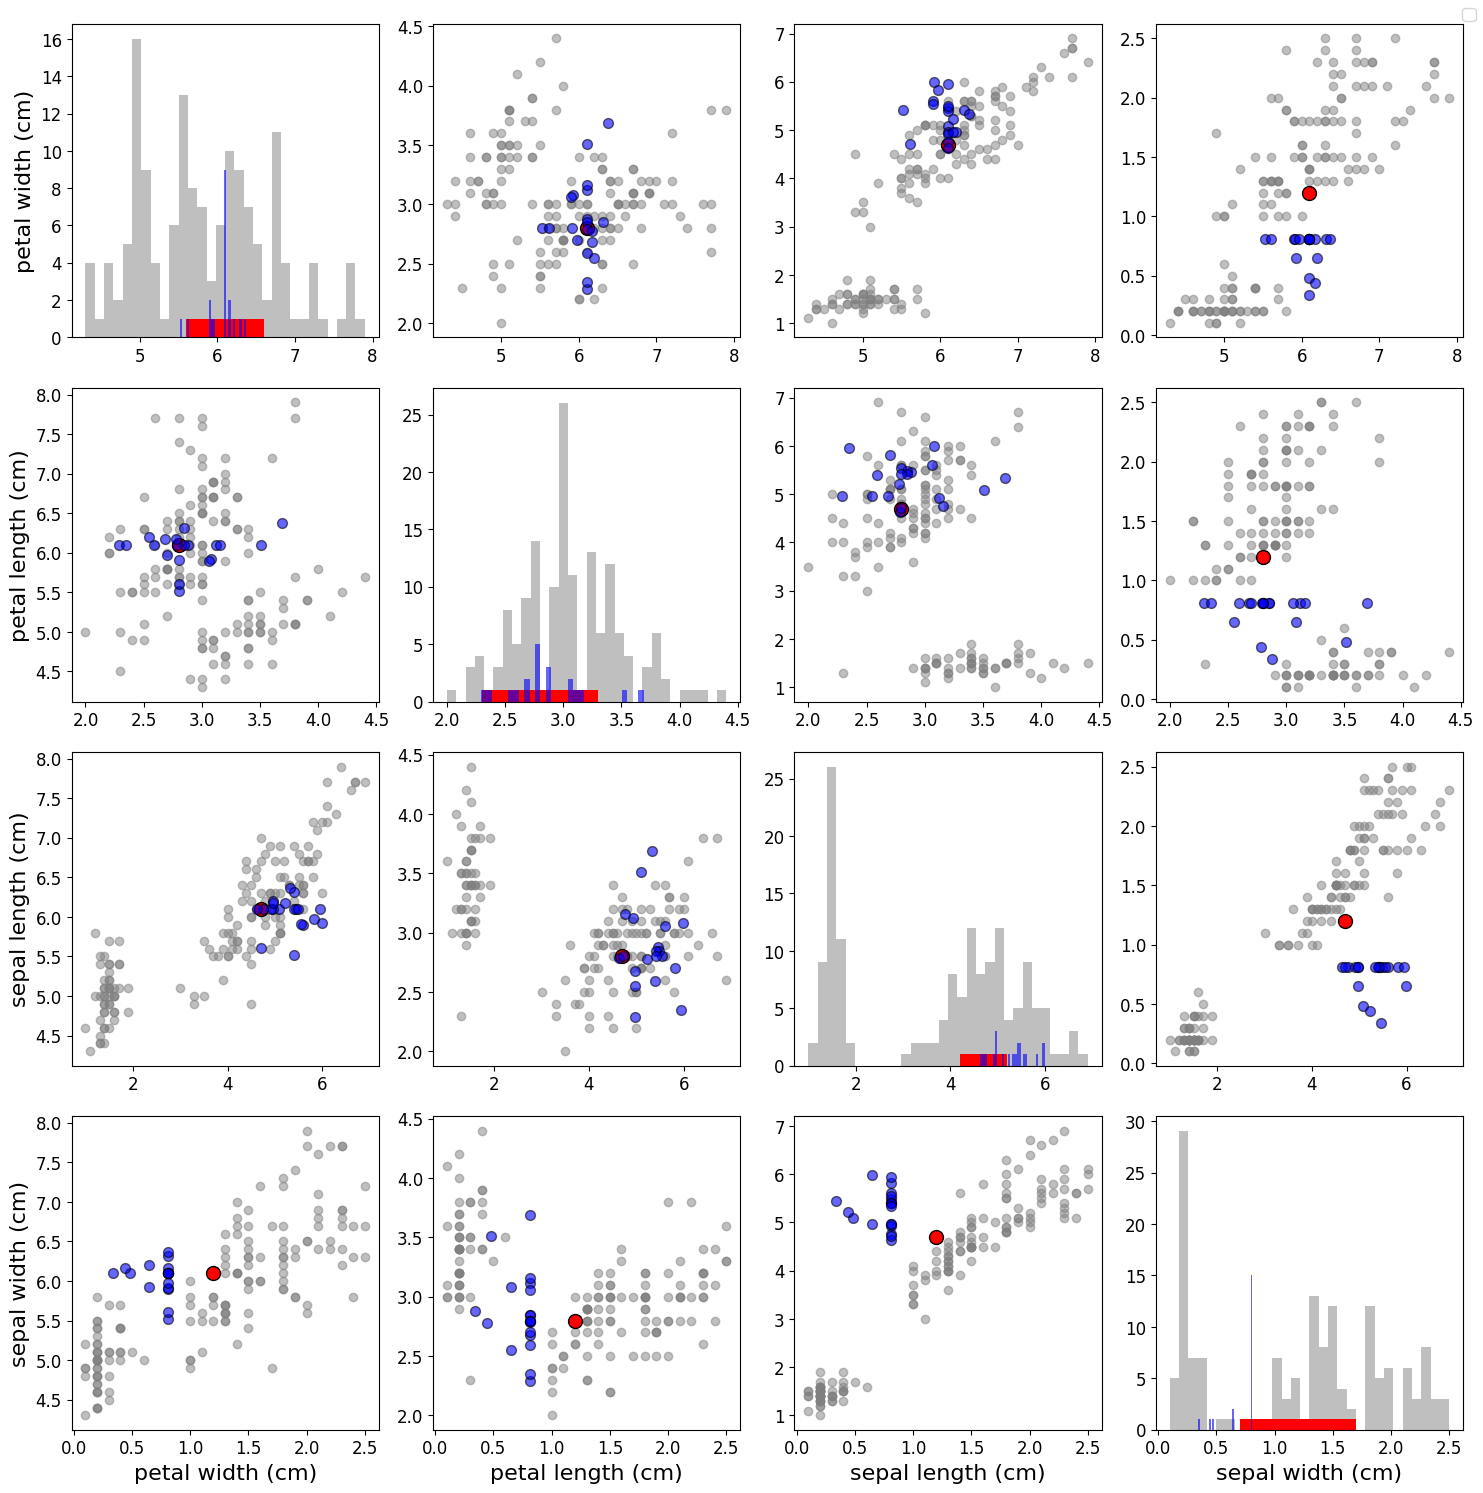

In [13]:
from CounterFactualVisualizer import plot_pairwise_with_counterfactual_df


sample = {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}
rules = ['no_change', 'non_increasing', 'non_decreasing']

# Generate all possible combinations of rules for each feature
feature_names = list(sample.keys())
rule_combinations = list(itertools.product(rules, repeat=len(feature_names)))

counterfactuals_df = []

for replicatons in range(20):
  # Iterate through each combination of rules
    #dict_non_actionable = {'sepal width (cm)': 'no_change', 'sepal length (cm)': 'non_increasing'}
    dict_non_actionable = {'sepal width (cm)': 'non_increasing'}

    # Create an instance of the CounterFactualModel class
    cf_dpg = CounterFactualModel(model, constraints)
    cf_dpg.dict_non_actionable = dict_non_actionable

    # Generate counterfactual
    counterfactual = cf_dpg.generate_counterfactual(sample, target_class=2)
    if (counterfactual == None):
        continue

    plot_sample_and_counterfactual_heatmap(sample, predicted_class, counterfactual,  model.predict(pd.DataFrame([counterfactual])),  dict_non_actionable)

    # Prepare data for DataFrame
    cf_data = counterfactual.copy()
    cf_data.update({'Rule_' + k: v for k, v in dict_non_actionable.items()})

    # Append to DataFrame
    counterfactuals_df.append(cf_data)

counterfactuals_df = pd.DataFrame(counterfactuals_df)
# Displaying the DataFrame
print(counterfactuals_df)

plot_pairwise_with_counterfactual_df(model, X, y, sample, counterfactuals_df)